In [ ]:
import torch
import lpips
import time

# Example input (1, 3, H, W), scaled to [-1, 1]
img1 = torch.randn(1, 3, 256, 256).to('cuda') * 2 - 1
img2 = torch.randn(1, 3, 256, 256).to('cuda') * 2 - 1

loss_fn = lpips.LPIPS(net='vgg').to('cuda')

# Warm-up
_ = loss_fn(img1, img2)

# Measure time
start = time.time()
for _ in range(100):  # Run multiple times to average
    _ = loss_fn(img1, img2)
end = time.time()

avg_time = (end - start) / 100  # Average per pair
print(f"Average LPIPS time per pair: {avg_time * 1000:.2f} ms")


ModuleNotFoundError: No module named 'lpips'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
def add_gaussian_noise(image, snr_db=10):
    """
    Adds Gaussian noise to an image while maintaining a given SNR (in dB).

    Args:
        image (torch.Tensor): Input image tensor (range 0-1 or 0-255).
        snr_db (float): Desired Signal-to-Noise Ratio in dB.

    Returns:
        torch.Tensor: Noisy image.
    """
    image = image.float()  # Ensure float type
    signal_power = torch.mean(image ** 2)  # Compute signal power
    noise_power = signal_power / (10 ** (snr_db / 10))  # Compute required noise power

    # Generate Gaussian noise
    noise = torch.randn_like(image) * torch.sqrt(noise_power)

    # Add noise to the image
    data = image + noise
    noisy_image = (data - data.min())/(data.max() - data.min())
    return noisy_image  # Clip values to valid range

In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image  # For image datasets
import torch

class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None,inverse_func):
        """
        Args:
            data_dir (str): Path to data directory.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_dir = data_dir
        self.transform = transform
        self.inverse_func=inverse_func
        self.data_list = os.listdir(data_dir)  # Assuming each file is a data sample

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index
        Returns:
            sample: Loaded data item (image/tensor) and label if available.
        """
        file_name = self.data_list[idx]
        file_path = os.path.join(self.data_dir, file_name)

        # Example: loading image
        image = Image.open(file_path).convert('RGB')
        inverse_image=self.inverse_func(image)
        if self.transform:
            image = self.transform(image)
            inverse_image=self.transform(inverse_image)

        return inverse_image, image

# Example transforms
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust as needed
])

# Instantiate dataset
train_dataset = CustomDataset(data_dir='path/to/data', transform=transform)

# DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Example: Iterate over DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)


In [ ]:
import json

# Function to write results to a JSON file
#def write_results_to_json(results, filename):
 #   with open(filename, 'w') as f:
  #      json.dump(results, f, indent=4)  # Write with indentation for readability

# Example usage
results = {
    "Siren": [[0.92, 0.85, 0.88]],
    "Siren-finetuned": [[0.95, 0.90, 0.92]],
    "Strainer(encoder learned from 1 image)": [[0.87, 0.89, 0.91]],
    "Strainer (proposed, learned from 10 images)": [[0.90, 0.92, 0.93]]
}

# Write the results to 'results.json'
#write_results_to_json(results, 'results.json')


In [ ]:
import json
from matplotlib import pyplot as plt
import numpy as np
# Function to read results from a JSON file
def read_results_from_json(filename):
    with open(filename, 'r') as f:
        results = json.load(f)  # Load JSON data as a dictionary
    return results

# Example usage
results_ct = read_results_from_json('/content/drive/MyDrive/celeba_hq_10_100/results.json')

# Now the results can be used directly as a Python dictionary or converted to a list
print("Extracted Results:")
print(len(results_ct['Siren']))


Extracted Results:
34


<ipython-input-12-a60d0ee07f8a>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(results_data))  # Using 'tab10' colormap for distinct colors


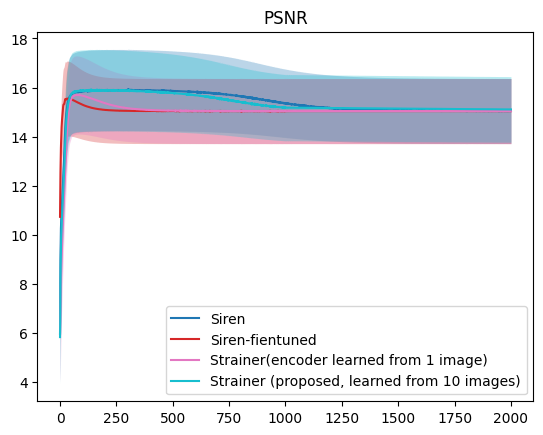

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def count_bound(matrix):
  iter_list=[]
  for iteration in matrix:
    mean=np.mean(iteration)
    std=np.std(iteration)
    iter_list.append([mean,std])
  return iter_list
def count_result_matrix(result,key,iter_number):
  psnr_list=[[] for _ in range(iter_number)]
  ssim_list=[[] for _ in range(iter_number)]
  lpip_list=[[] for _ in range(iter_number)]
  for testcase in result[key]:
    for iteration in range(iter_number):
      psnr_list[iteration].append(testcase[iteration][0])
      ssim_list[iteration].append(testcase[iteration][1])
      lpip_list[iteration].append(testcase[iteration][2])
  psnr_list=count_bound(psnr_list)
  ssim_list=count_bound(ssim_list)
  lpip_list=count_bound(lpip_list)

  return psnr_list,ssim_list,lpip_list

#np.mean, np.std
def draw_result(results_data, choose=0,title=''):
    # Create a color palette (you can adjust this to your preference)
    color_palette = cm.get_cmap('tab10', len(results_data))  # Using 'tab10' colormap for distinct colors

    for idx, (key, item) in enumerate(results_data.items()):
        psnr_list, ssim_list, lpip_list = count_result_matrix(results_data, key, 2001)
        graph_list = [psnr_list, ssim_list, lpip_list][choose]
        x = np.linspace(0, 2000, 2001)

        # Pick the color from the palette
        line_color = color_palette(idx)  # Get the color for the line
        fill_color = line_color[:3] + (0.3,)  # Adjust opacity for the fill (making it lighter)

        # Plot the line
        plt.plot(x, [float(x[0]) for x in graph_list], label=key, color=line_color)

        # Use fill_between with proper lists of y1 and y2
        plt.fill_between(x,
                         [float(x[0] - x[1]) for x in graph_list],  # Lower bound
                         [float(x[0] + x[1]) for x in graph_list],  # Upper bound
                         alpha=0.3, edgecolor=line_color, facecolor=fill_color, linewidth=0)
    plt.title(title)
    plt.legend()
    plt.show()
draw_result(results_ct,title='PSNR')


<ipython-input-12-a60d0ee07f8a>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(results_data))  # Using 'tab10' colormap for distinct colors


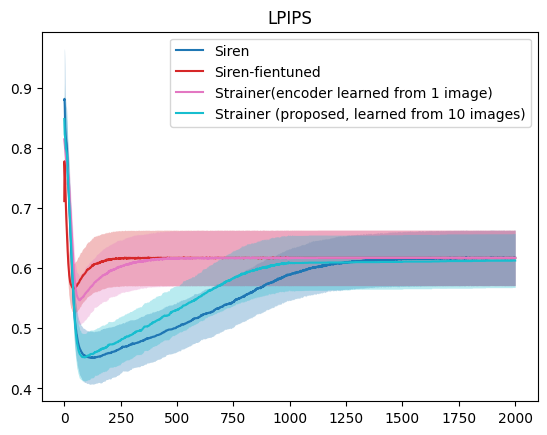

In [ ]:
draw_result(results_ct,2,title='LPIPS')

<ipython-input-12-a60d0ee07f8a>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(results_data))  # Using 'tab10' colormap for distinct colors


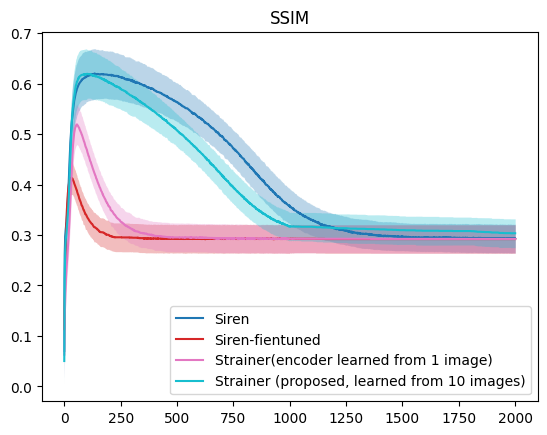

In [ ]:
draw_result(results_ct,1,title='SSIM')

In [ ]:
draw_result(results,0)
draw_result(results,1)
draw_result(results,2)

<ipython-input-7-a60d0ee07f8a>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(results_data))  # Using 'tab10' colormap for distinct colors


TypeError: 'float' object is not subscriptable

In [ ]:
print(results_ct['Siren'])

[[[12.2, 0.25, 0.64], [13.34, 0.18000000715255737, 0.74], [13.97, 0.1899999976158142, 0.73], [14.22, 0.20000000298023224, 0.73], [14.15, 0.20000000298023224, 0.73], [14.71, 0.20999999344348907, 0.72], [15.24, 0.2199999988079071, 0.7], [15.7, 0.23999999463558197, 0.69], [16.07, 0.23999999463558197, 0.69], [16.46, 0.25, 0.68], [17.31, 0.2800000011920929, 0.65], [17.96, 0.3700000047683716, 0.62], [18.49, 0.4000000059604645, 0.62], [18.65, 0.3799999952316284, 0.62], [19.09, 0.4399999976158142, 0.6], [19.79, 0.5, 0.58], [20.19, 0.5099999904632568, 0.57], [20.32, 0.5099999904632568, 0.57], [20.26, 0.5, 0.57], [20.69, 0.5099999904632568, 0.56], [21.27, 0.5299999713897705, 0.55], [21.59, 0.5299999713897705, 0.55], [21.7, 0.5099999904632568, 0.55], [21.69, 0.4699999988079071, 0.55], [21.96, 0.46000000834465027, 0.55], [22.44, 0.49000000953674316, 0.54], [22.75, 0.5199999809265137, 0.53], [22.95, 0.5199999809265137, 0.53], [23.05, 0.5099999904632568, 0.53], [23.09, 0.5099999904632568, 0.52], [23

<ipython-input-13-22eeecc06c21>:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_palette = cm.get_cmap('tab10', len(results_data))  # Using 'tab10' colormap for distinct colors


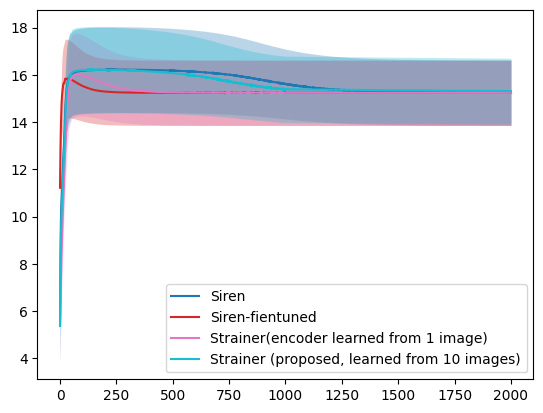

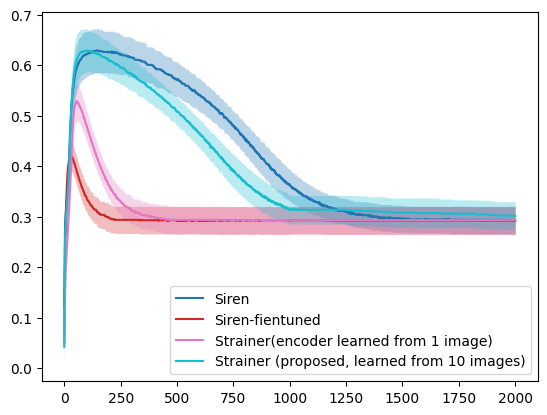

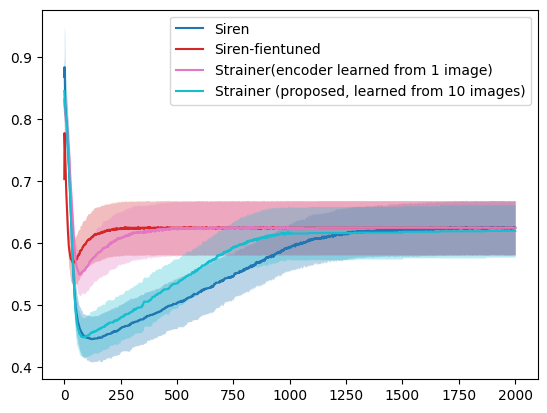

In [ ]:
draw_result(results_ct,0)
draw_result(results_ct,1)
draw_result(results_ct,2)